In [11]:
import sys
sys.path.append("../../src/")
sys.path.append("../../utilities/")
import dataset_class
from dataset_class import dataset
import data_utils
import evaluation_utils
from importlib import reload
dataset_class = reload(dataset_class)
data_utils = reload(data_utils)
from dataset_class import dataset
from GMM_GBR import GMM_MP
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mrf_util
from mrf import MarkovRandomField

In [2]:
GM12878_signals_names = ['DNase', 'H3K4me2', 'H3K27ac', 'H2A.Z', 'H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K9ac', 'H3K4me3', 'H3K36me3', 'H3K79me2', 'H4K20me1']
GM12878_dataset = dataset('GM12878', 'hg19', 10000, '../../data/GM12878/hg19/Hi-C/GSE63525_GM12878_insitu_primary_30.hic',
                 '../../utilities/juicer_tools_1.22.01.jar', '../../data/GM12878/hg19/Hi-C/res10000',
                 GM12878_signals_names, '../../data/GM12878/hg19/genomic-assays/bin_10000/', 
                  '../../data/GM12878/hg19/res10000_datasets/',
                  '../../data/', '../../utilities/config.json')
GM12878_dataset.load_pos2ind_and_ind2pos_maps('../../data/valid_bins/hg19/GM12878_10000_bins.txt')
###########GM12878_dataset.generate_signals_and_bin_files()
###########GM12878_dataset.generate_significant_interactions_file('short',0.000001)
#signal_path = '../../data/GM12878/hg19/res10000_datasets/signals.txt'
#bin_path = '../../data/GM12878/hg19/res10000_datasets/bin.txt'
#genomedata_path = '../../data/GM12878/hg19/res10000_datasets/signals.genomedata'
#data_utils.InputsAndBins_to_genomedata(signal_path, GM12878_signals_names, bin_path, 'hg19', 10000, genomedata_path)

In [8]:
signals_path = "../../data/GM12878/hg19/res10000_datasets/signals.txt"
bins_path = "../../data/GM12878/hg19/res10000_datasets/bin.txt"
short_hic_path = "../../data/GM12878/hg19/res10000_datasets/short_range_interactions.txt"

In [9]:
gmm_mp_args = {"i": signals_path, "e": short_hic_path, "g": bins_path, "r": 1, "n": 5, 
              "il": 5, "ml": 5, "w": 1, "o": 'GM12878_res10000_mp', "mp": '../../alternatives/segway-gbr-master/measureProp/MP_large_scale'}
gmm_mp = GMM_MP(gmm_mp_args)
gmm_mp.write_mp_graph()
gmm_mp.GMM_train()
gmm_mp.GMM_inference(0)
for l in range(5):
    gmm_mp.write_mp_post(l+1)
    gmm_mp.run_measure_prop(l+1)
    gmm_mp.read_mp_post(l+1)
    gmm_mp.GMM_inference(l+1)

writing mp graph file...
writing mp transduction file...


In [66]:
for i in range(5):
    GM12878_dataset.write_annotation(gmm_mp.iters_labels[i], 'gmm_mp_{}'.format(i))

In [16]:
from scipy.stats import entropy
hic = np.loadtxt(short_hic_path, dtype = int)
def labels_stat(hic, labels):
    first_label = [labels[p] for p in hic[:,0]]
    second_label = [labels[p] for p in hic[:,1]]
    same_ratio = sum([f==s for f,s in zip(first_label,second_label)])/len(first_label)
    _, label_counts = np.unique(labels, return_counts = True)
    labels_entropy = entropy(label_counts, base=None)
    return {'same_ratio': same_ratio, 'labels_entropy': labels_entropy}
hic_same_ratios = []
for l in range(5):
    hic_same_ratio = labels_stat(hic, gmm_mp.iters_labels[l])['same_ratio']
    hic_same_ratios.append(hic_same_ratio)

In [13]:
normalized_TAD_enrichments = []
for i in np.arange(5):
    score = GM12878_dataset.normalized_TAD_agreement('../../data/GM12878/hg19/annotations/GSE63525_GM12878_primary+replicate_Arrowhead_domainlist.txt', gmm_mp.iters_labels[i], 20)
    normalized_TAD_enrichments.append(score)

In [20]:
stat_df = pd.DataFrame({'iteration': np.arange(0,5), 'TAD_enrichment': normalized_TAD_enrichments,
                       'same_label_ratio': hic_same_ratios})

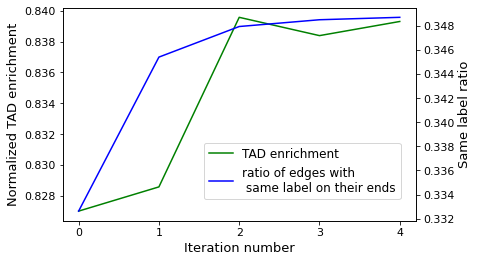

In [58]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize = (7,4))
ax = sns.lineplot(data = stat_df, x = 'iteration', y = 'TAD_enrichment', color = 'g', legend = False)
ax.set_xlabel('Iteration number', size = 13)
ax.set_ylabel('Normalized TAD enrichment', size = 13)
ax.tick_params(axis='both', which='major', labelsize=11)
ax2 = plt.twinx()
sns.lineplot(data= stat_df, x = 'iteration', y = 'same_label_ratio', color = 'b', legend = False, ax=ax2)
ax2.set_ylabel('Same label ratio', size = 13)
ax2.tick_params(axis='both', which='major', labelsize=11)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(handles=[Line2D([], [], color='g', label='TAD enrichment'), Line2D([], [], color='b', label='ratio of edges with \n same label on their ends')], loc=(0.4,0.1), prop={'size': 12})

fig.tight_layout(pad=2.0)
fig.savefig("GM12878_res10000_results/GMM_MP_TAD.png", 
            format="png", dpi=300, bbox_inches="tight", pad_inches=0.2, facecolor='white', transparent=False)

In [60]:
mrf_signals = mrf_util.readData(signals_path)
mrf_bins = mrf_util.readBedGraph(bins_path)
n = mrf_signals.shape[0]
mrf_hic = mrf_util.create_hic_matrix(short_hic_path, n, True)

In [61]:
hmrf = MarkovRandomField(n, mrf_hic, mrf_signals, 'mrf', 5, 5, 0.01)
hmrf.init_gmm()
hmrf.init_trans()
hmrf.solve()

In [65]:
for i in range(5):
    GM12878_dataset.write_annotation(hmrf.iters_labels[i], 'hmrf_{}'.format(i))

In [63]:
hmrf_hic_same_ratios = []
for l in range(5):
    hmrf_hic_same_ratio = labels_stat(hic, hmrf.iters_labels[l])['same_ratio']
    hmrf_hic_same_ratios.append(hmrf_hic_same_ratio)

In [67]:
hmrf_normalized_TAD_enrichments = []
for i in np.arange(5):
    score = GM12878_dataset.normalized_TAD_agreement('../../data/GM12878/hg19/annotations/GSE63525_GM12878_primary+replicate_Arrowhead_domainlist.txt', hmrf.iters_labels[i], 20)
    hmrf_normalized_TAD_enrichments.append(score)

In [70]:
hmrf_stat_df = pd.DataFrame({'iteration': np.arange(0,5), 'TAD_enrichment': hmrf_normalized_TAD_enrichments,
                       'same_label_ratio': hmrf_hic_same_ratios})

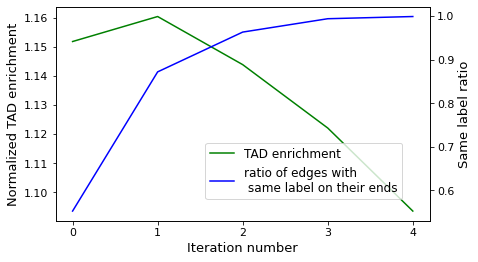

In [73]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize = (7,4))
ax = sns.lineplot(data = hmrf_stat_df, x = 'iteration', y = 'TAD_enrichment', color = 'g', legend = False)
ax.set_xlabel('Iteration number', size = 13)
ax.set_ylabel('Normalized TAD enrichment', size = 13)
ax.tick_params(axis='both', which='major', labelsize=11)
ax2 = plt.twinx()
sns.lineplot(data= hmrf_stat_df, x = 'iteration', y = 'same_label_ratio', color = 'b', legend = False, ax=ax2)
ax2.set_ylabel('Same label ratio', size = 13)
ax2.tick_params(axis='both', which='major', labelsize=11)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(handles=[Line2D([], [], color='g', label='TAD enrichment'), Line2D([], [], color='b', label='ratio of edges with \n same label on their ends')], loc=(0.4,0.1), prop={'size': 12})

fig.tight_layout(pad=2.0)
fig.savefig("GM12878_res10000_results/GMM_MRF_TAD.png", 
            format="png", dpi=300, bbox_inches="tight", pad_inches=0.2, facecolor='white', transparent=False)

In [77]:
pd.read_csv('../../data/GM12878/hg19/res10000_datasets/annotations/hmrf_4_annotation.txt', sep = "\t", header = None)

,0,1,2,3
0,chr1,530000,540000,0
1,chr1,560000,570000,2
2,chr1,710000,2590000,2
3,chr1,2610000,2640000,2
4,chr1,2680000,2690000,4
...,...,...,...,...
48641,chr22,49620000,50370000,2
48642,chr22,50410000,51180000,2
48643,chr22,51180000,51190000,0
48644,chr22,51190000,51200000,2


In [81]:
pd.read_csv('../../data/GM12878/hg19/res10000_datasets/annotations/gmm_mp_4_annotation.txt', sep = "\t", header = None)

,0,1,2,3
0,chr1,530000,540000,0
1,chr1,560000,570000,3
2,chr1,710000,720000,3
3,chr1,720000,750000,2
4,chr1,750000,760000,4
...,...,...,...,...
84660,chr22,51170000,51190000,0
84661,chr22,51190000,51200000,1
84662,chr22,51200000,51210000,0
84663,chr22,51210000,51220000,2
